In [924]:
import dtw
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp
import palantir
import scFates as scf

%matplotlib inline

sys.path.append("/home/sergey/tools/sclitr/")
import sclitr as sl

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())

sys.path.append("/home/sergey/tools/mmbench/")
import mmbench as mb

import warnings
warnings.filterwarnings("ignore")

In [925]:
def manual_test(adata, columns=None):
    from tqdm import tqdm
    from rpy2.robjects.packages import importr
    from rpy2.robjects import Formula
    
    rmgcv = importr("mgcv")
    
    fitted = {}
    if columns is None:
        genes = adata.var_names
        df = pd.DataFrame(adata.X.A, columns=genes, index=adata.obs_names)
        colnames = genes
    else:
        df = adata.obs[columns]
        colnames = columns
        
    df["t"] = adata.obs["t"]
    
    for col in tqdm(colnames):
        df_tmp = df[[col, "t"]]
        df_tmp.columns = ["exp", "t"]
        m = rmgcv.gam(Formula("exp ~ s(t, k = 5)"), data=df_tmp)
        p = rmgcv.predict_gam(m)
        fitted[col] = p
        
    if columns is None:
        adata.layers["fitted"] = pd.DataFrame(fitted).values
    else:
        for col in colnames:
            adata.obs[col + "_fitted"] = fitted[col]

In [926]:
scv.set_figure_params(dpi=300, dpi_save=300)
sc.set_figure_params(dpi=150, dpi_save=300)
sns.set_style("ticks")

In [927]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [956]:
adata_2 = sc.read_h5ad("pathes_objects/path_2_full.h5ad")
adata_8 = sc.read_h5ad("pathes_objects/path_8_full.h5ad")

In [957]:
def rotate_points(points, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    rotated_points = np.dot(points, rotation_matrix)
    return rotated_points

UMAP1 = adata_2.obsm["X_umap"][:, [1, 0]]
UMAP1[:, 0] = -UMAP1[:, 0] + max(UMAP1[:, 0])
UMAP1[:, 0] += 12
UMAP1[:, 1] = (UMAP1[:, 1] - min(UMAP1[:, 1])) / (max(UMAP1[:, 1]) - min(UMAP1[:, 1]))

UMAP2 = adata_8.obsm["X_umap"][:, [1, 0]]
UMAP2[:, 0] = -UMAP2[:, 0] + max(UMAP2[:, 0])
UMAP2 = rotate_points(UMAP2, 0.4)
UMAP2[:, 1] = (UMAP2[:, 1] - min(UMAP2[:, 1])) / (max(UMAP2[:, 1]) - min(UMAP2[:, 1])) * 0.9 + 0.05

UMAP = np.concatenate([UMAP1, UMAP2])

adata_plot = adata_2.concatenate(adata_8)
adata_plot.obsm["X_umap"] = UMAP.copy()
adata_plot.obs_names = [i.split("-")[0] for i in adata_plot.obs_names]

In [958]:
adata_combined = sc.read_h5ad("dtw/adata_combined.h5ad")
adata_2 = sc.read_h5ad("dtw/path2.h5ad")
adata_8 = sc.read_h5ad("dtw/path8.h5ad")

## Identification of bone-related signature

In [1074]:
sc.tl.rank_genes_groups(adata_plot, groupby="milestones", groups=["Bone"], reference="Cartilage")

bone_genes = sc.get.rank_genes_groups_df(adata_plot, group="Bone")[
    (sc.get.rank_genes_groups_df(adata_plot, group="Bone").logfoldchanges > 4) &
    (sc.get.rank_genes_groups_df(adata_plot, group="Bone").pvals_adj < 1e-20)
].names
bone_genes = bone_genes[bone_genes != "Runx2"]

expr = adata_2[adata_2.obs.t.sort_values().index, bone_genes].X
bone_genes = np.array(bone_genes)[np.argsort(expr.mean(axis=0).A[0])[::-1]][:20]

print("Signature size:", len(bone_genes))

sc.tl.score_genes(adata_plot, gene_list=bone_genes, score_name="bone_score")

Signature size: 20


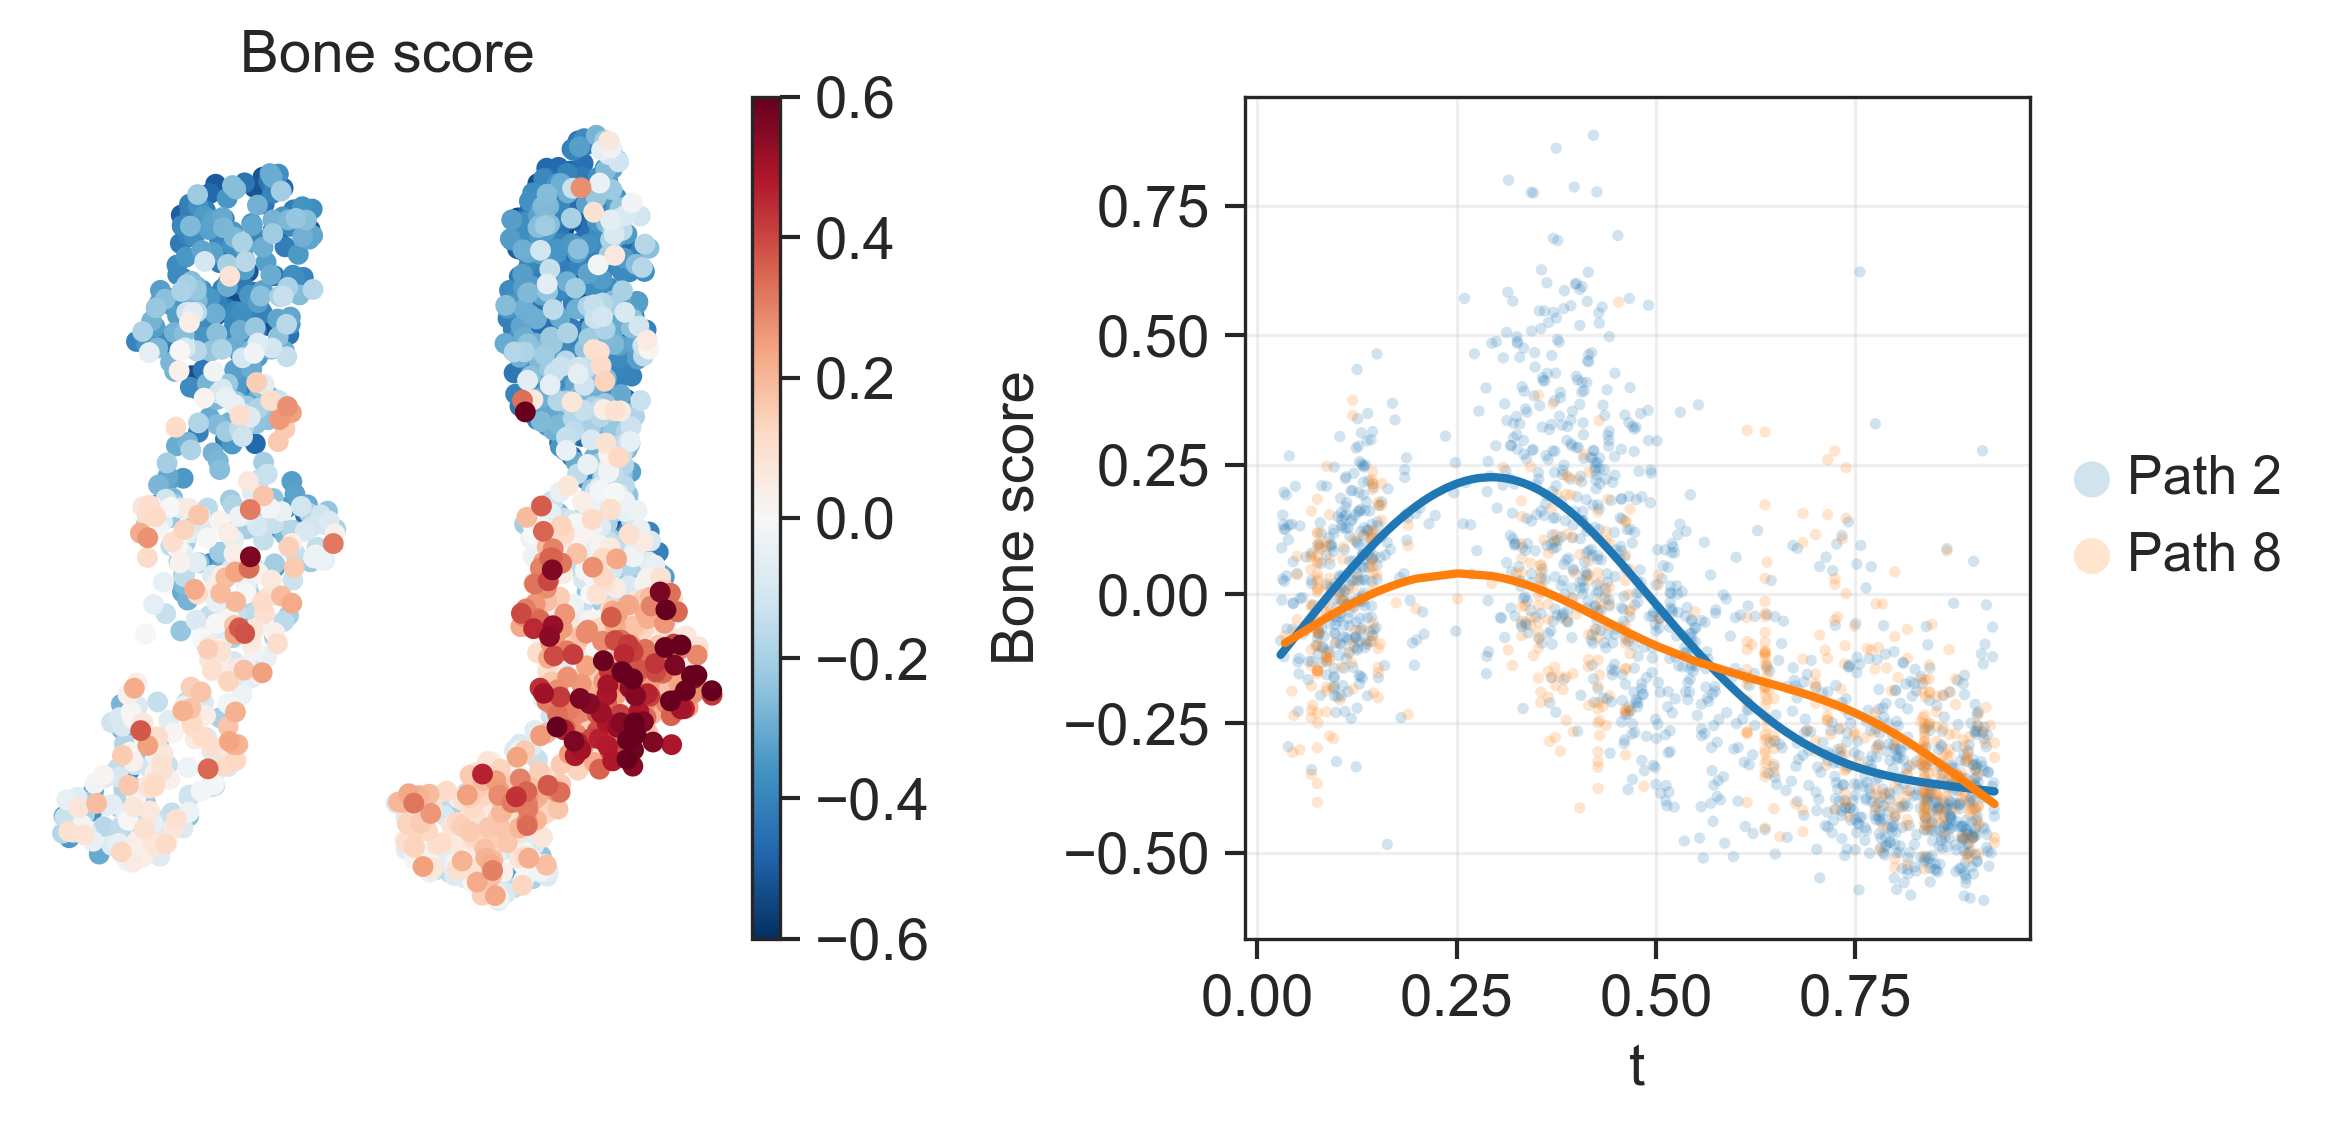

In [1077]:
adata_draw = sc.AnnData(
    X=np.matrix(np.matrix(adata_plot[adata_combined.obs_names].obs["bone_score"]).T),
    var=pd.DataFrame(index=["bone_score"]),
    obs=adata_combined.obs[["path", "t"]]
)

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(adata_plot[adata_plot.obs.seg != "3"], color="bone_score", cmap="RdBu_r",
           vmax=0.6, vmin=-0.6, s=100, ax=axes[0], show=False, frameon=False, title="Bone score")

scf.pl.trend_covariate(
    adata_draw,
    gene="bone_score",
    group_key="path",
    alpha=0.2,
    size=30,
    show=False,
    ax=axes[1],
)
axes[1].grid(alpha=0.3)
axes[1].set_ylabel("Bone score")
axes[1].set_title("")

fig.tight_layout()

plt.savefig("figures/bone_related_genes/bone_score.pdf", bbox_inches="tight")

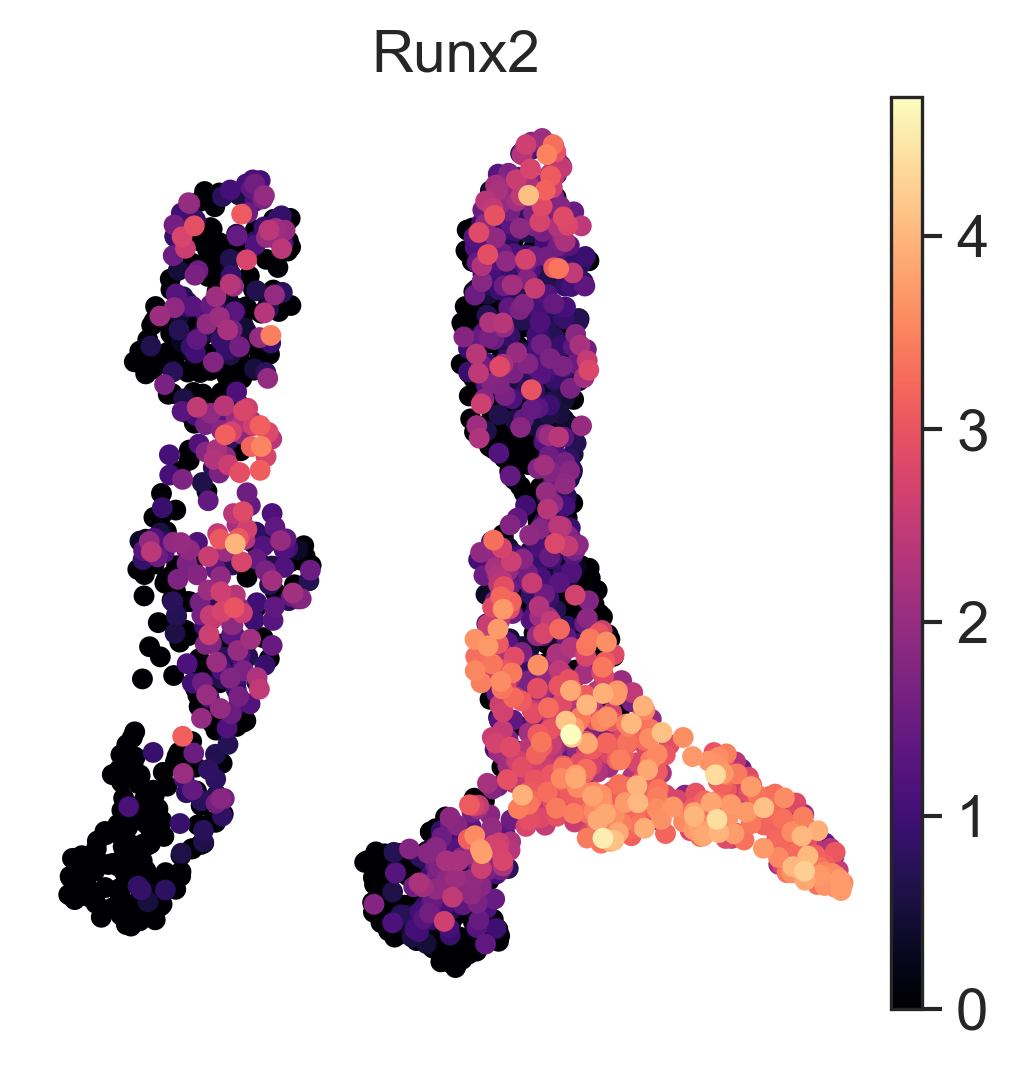

In [1098]:
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(adata_plot, color="Runx2", cmap="magma", ax=ax, show=False,
           s=100, frameon=False, title="Runx2")

plt.savefig("figures/bone_related_genes/Runx2_all.pdf", bbox_inches="tight")

In [1161]:
adata_plot_prebifurc = adata_plot.copy()
adata_plot_prebifurc = adata_plot_prebifurc[adata_combined.obs_names].copy()
adata_plot_prebifurc.obs["path"] = ["Cluster 8" if i == "1" else "Cluster 2" for i in adata_plot_prebifurc.obs.batch]

adata_plot_prebifurc.obs["t"] = adata_combined.obs["t"]

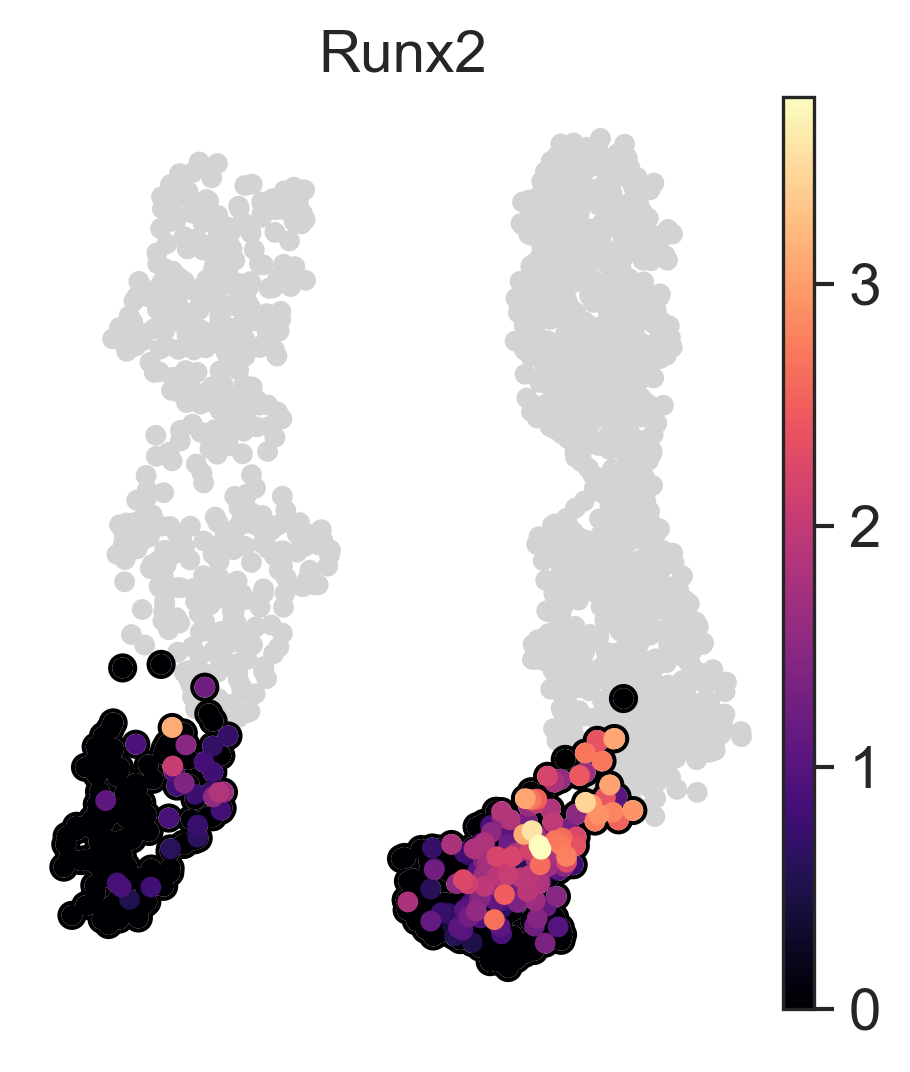

In [1162]:
fig, ax = plt.subplots(figsize=(3.5, 4))

sc.pl.umap(adata_plot_prebifurc, ax=ax, show=False, s=100, frameon=False)
sc.pl.umap(adata_plot_prebifurc[adata_plot_prebifurc.obs.t <= 0.3],  ax=ax, show=False, title="Runx2",
           s=100, frameon=False, add_outline=True, outline_width=(0.2, 0), color="Runx2", alpha=1, cmap="magma")

plt.savefig("figures/bone_related_genes/Runx2_progenitors.pdf")

PearsonRResult(statistic=-0.0005000183567667928, pvalue=0.9950410626659023)

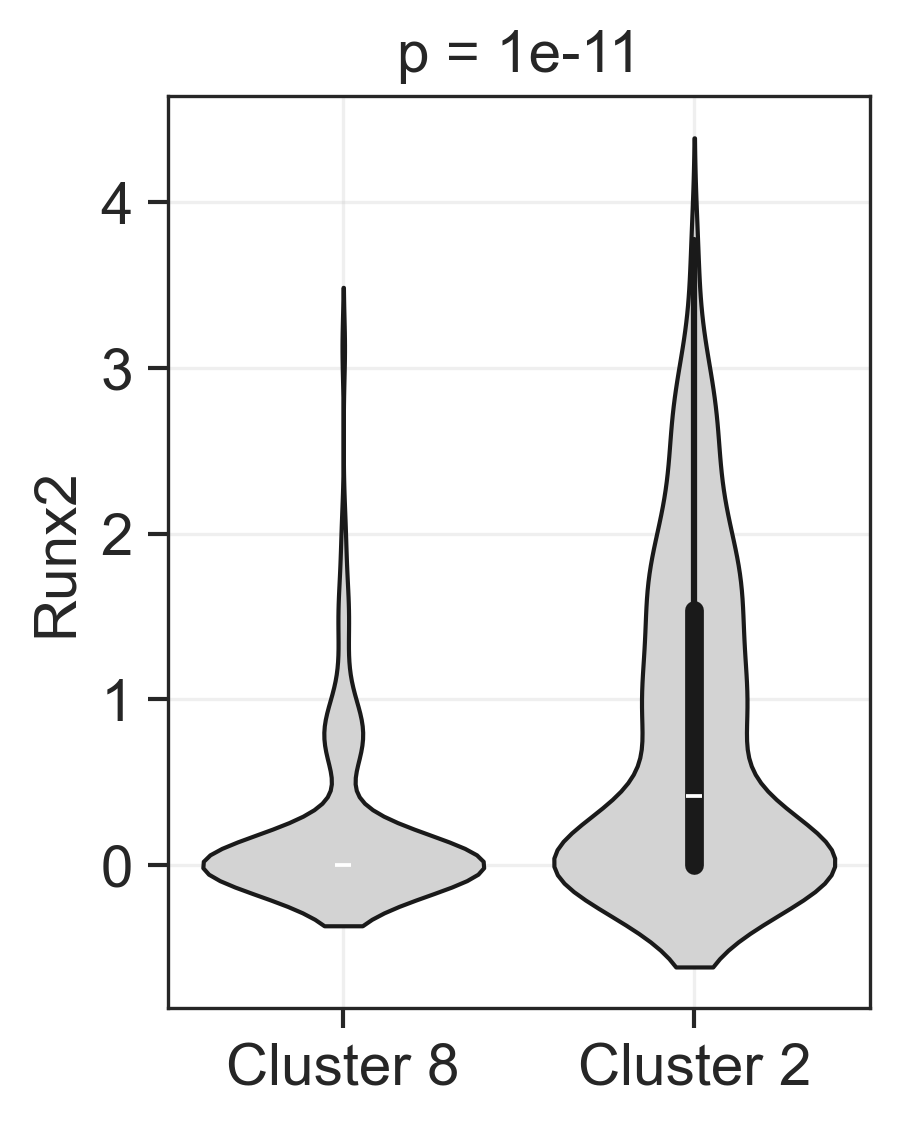

In [1212]:
from scipy.stats import ttest_ind

adata_tmp = adata_plot_prebifurc[adata_plot_prebifurc.obs.t <= 0.3].copy()

fig, ax = plt.subplots(figsize=(3, 4))

df = pd.DataFrame({"Runx2": adata_tmp[:, "Runx2"].X.A.T[0], "batch": adata_tmp.obs.batch})
df["batch"] = ["Cluster 8" if i == "1" else "Cluster 2" for i in df.batch]

p = int(np.log10(ttest_ind(df[df.batch == "Cluster 2"].Runx2, df[df.batch == "Cluster 8"].Runx2).pvalue))

sns.violinplot(
    x="batch",
    y="Runx2",
    data=df,
    ax=ax,
    density_norm="width",
    order=["Cluster 8", "Cluster 2"],
    color="lightgrey",
    edgecolor="k",
)
ax.grid(alpha=0.3)
ax.set_xlabel("")
ax.set_title(f"p = 1e{p}")

plt.savefig("figures/bone_related_genes/Runx2_violin.pdf")

pearsonr(bone_8, runx2_8)

In [1244]:
pearsonr(runx2_2, t_2).statistic

0.5528219889103284

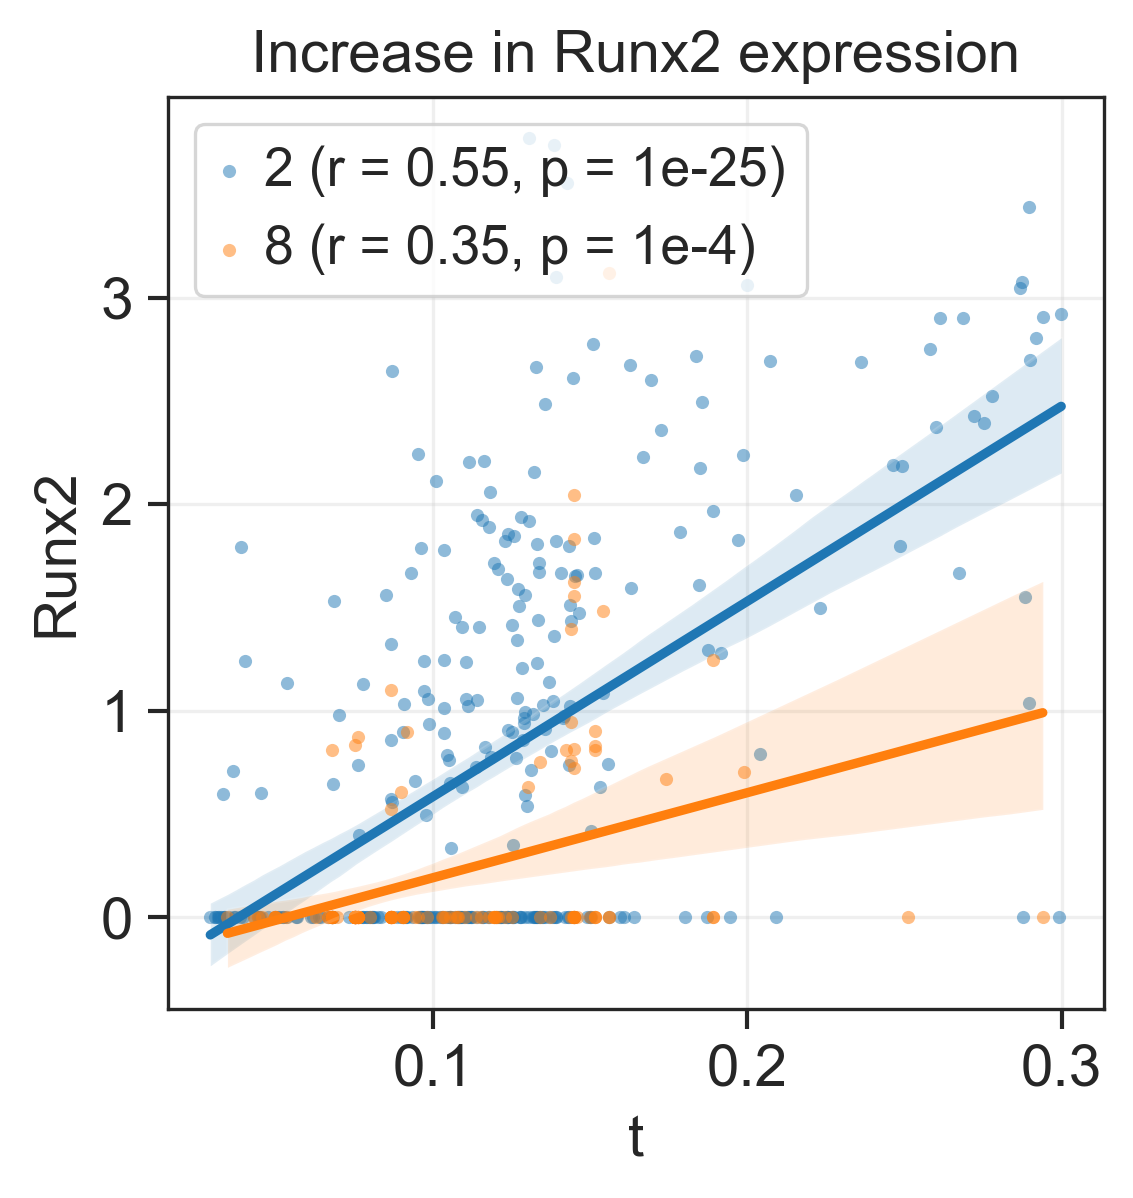

In [1252]:
runx2_2 = adata_tmp[adata_tmp.obs.path == "Cluster 2", "Runx2"].X.A.T[0]
runx2_8 = adata_tmp[adata_tmp.obs.path == "Cluster 8", "Runx2"].X.A.T[0]

t_2 = adata_tmp[adata_tmp.obs.path == "Cluster 2"].obs.t.values
t_8 = adata_tmp[adata_tmp.obs.path == "Cluster 8"].obs.t.values

r_8 = np.round(pearsonr(runx2_8, t_8).statistic, 2)
r_2 = np.round(pearsonr(runx2_2, t_2).statistic, 2)

p_8 = int(np.log10(pearsonr(runx2_8, t_8).pvalue))
p_2 = int(np.log10(pearsonr(runx2_2, t_2).pvalue))

fig, ax = plt.subplots(figsize=(4, 4))

sns.regplot(
    x=t_2,
    y=runx2_2,
    scatter_kws={"s": 10, "alpha": 0.5, "linewidth": 0},
    label=f"2 (r = {r_2}, p = 1e{p_2})",
)

sns.regplot(
    x=t_8,
    y=runx2_8,
    scatter_kws={"s": 10, "alpha": 0.5, "linewidth": 0},
    label=f"8 (r = {r_8}, p = 1e{p_8})",
)

ax.legend()
ax.grid(alpha=0.3)
ax.set_title("Increase in Runx2 expression")
ax.set_xlabel("t")
ax.set_ylabel("Runx2")

plt.savefig("figures/bone_related_genes/Runx2_increase.pdf")

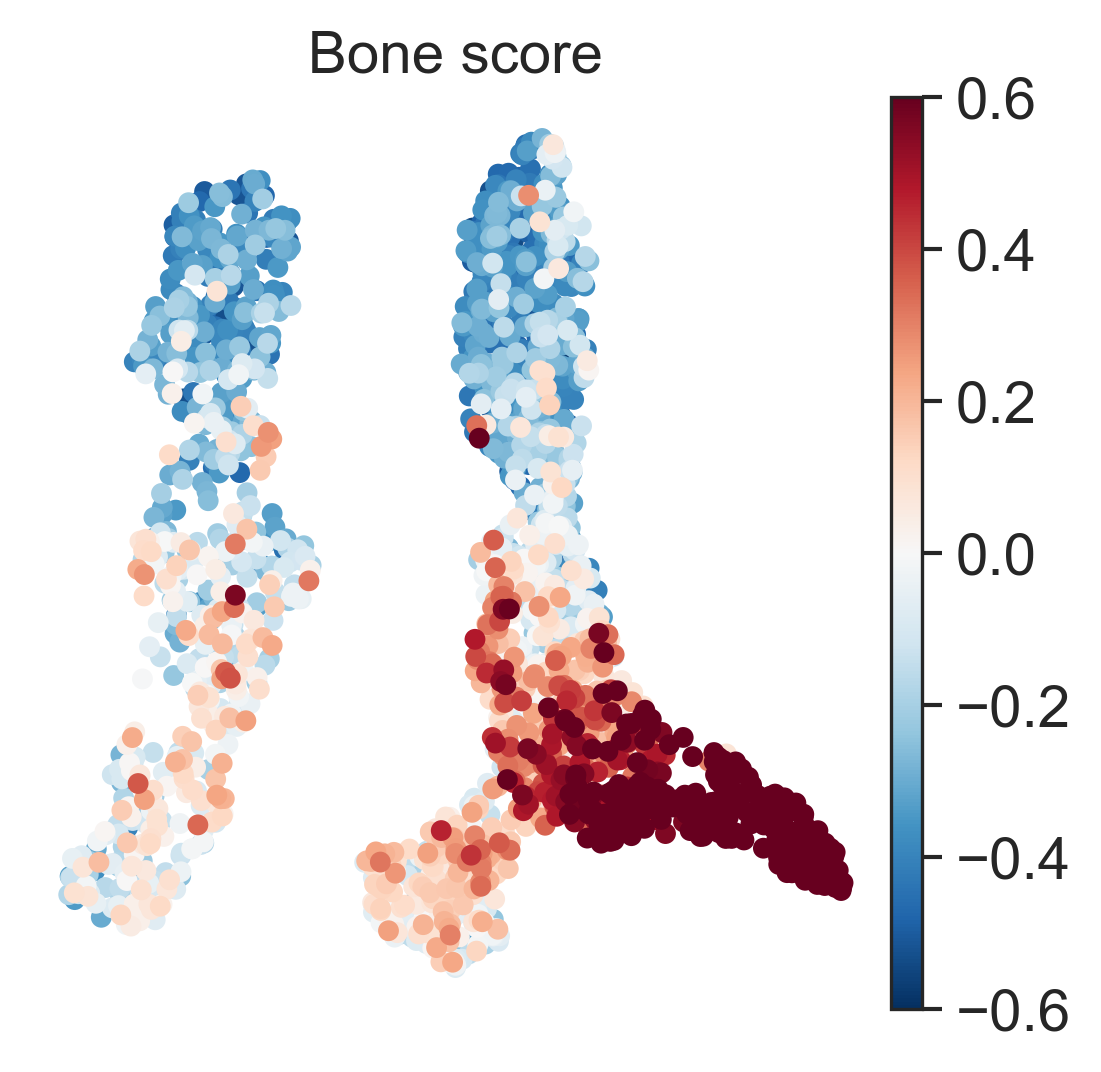

In [1094]:
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(adata_plot, color="bone_score", cmap="RdBu_r", ax=ax, show=False,
           vmax=0.6, vmin=-0.6, s=100, frameon=False, title="Bone score")

plt.savefig("figures/bone_related_genes/bone_score_all.pdf", bbox_inches="tight")

In [1079]:
from scipy.ndimage.filters import gaussian_filter
from scipy.sparse import csr_matrix

e = 100

genes = bone_genes.copy()

expr = adata_2[adata_2.obs.t.sort_values().index, genes].X
genes = np.array(genes)[np.argsort(expr.mean(axis=0).A[0])[::-1]]

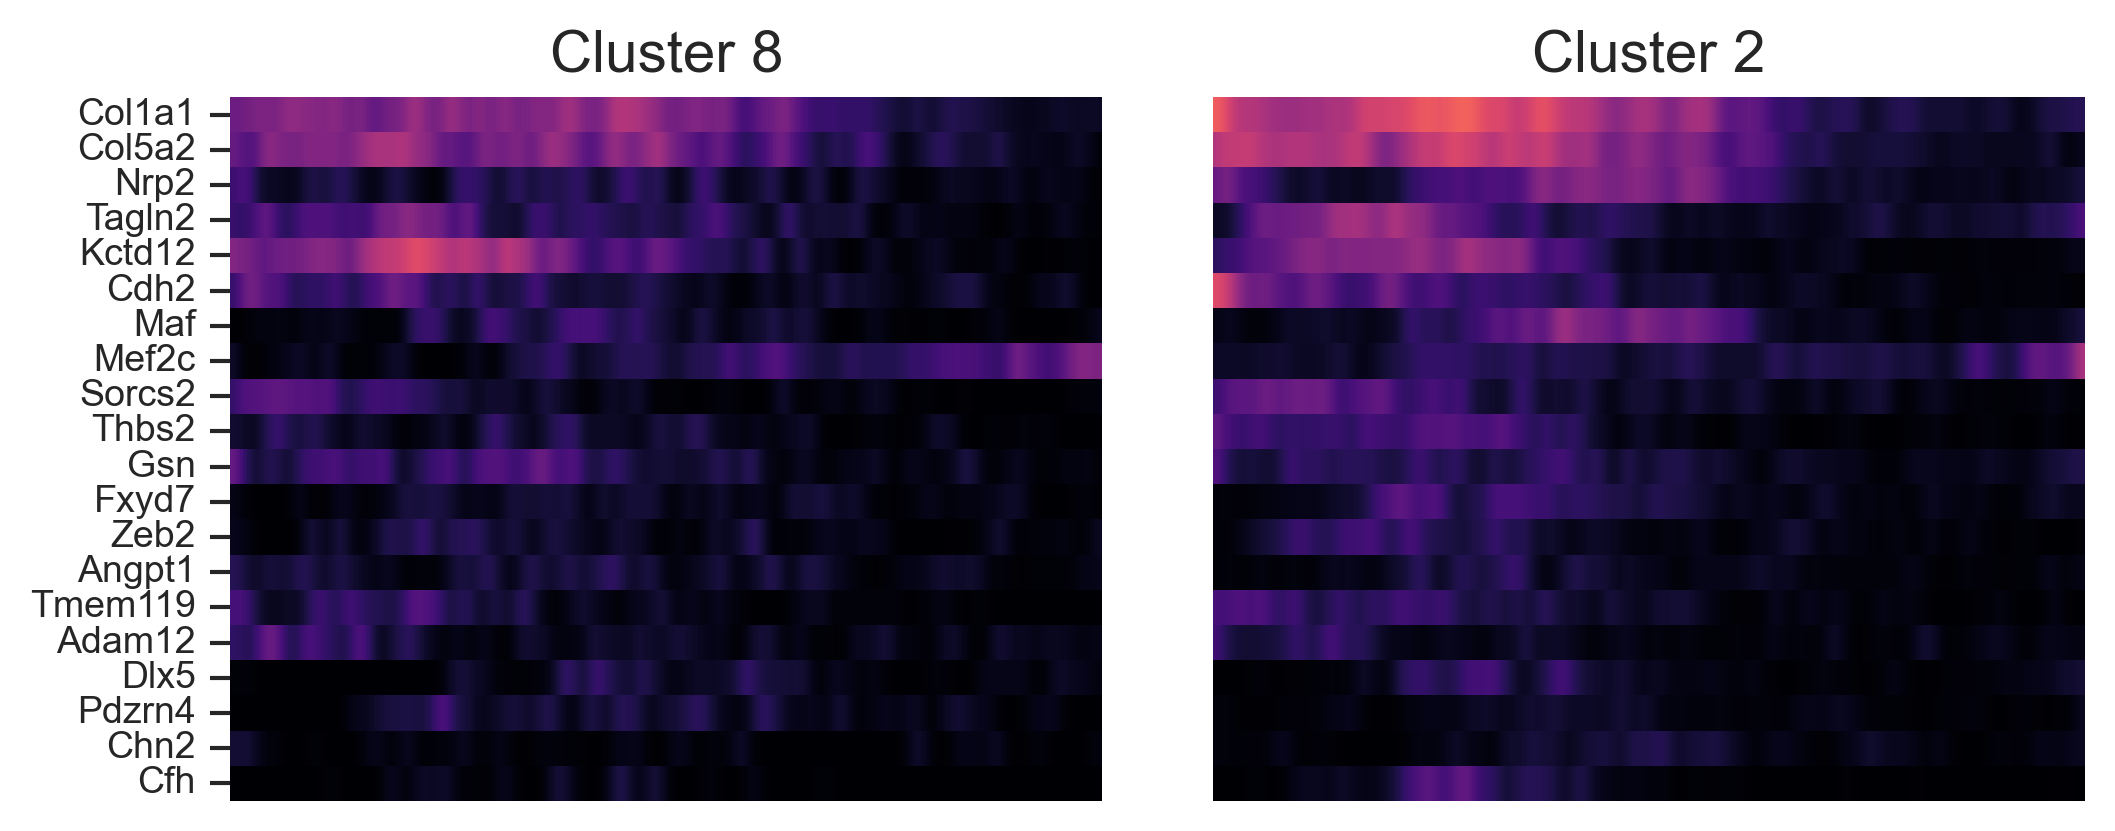

In [1081]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

adata_ = adata_8
data = adata_[adata_.obs.t.sort_values().index, genes].X
data = pd.DataFrame(
    (
        (data - np.minimum(adata_2[:, genes].X.A.min(axis=0), adata_8[:, genes].X.A.min(axis=0))) / 
        (
            np.maximum(adata_2[:, genes].X.A.max(axis=0), adata_8[:, genes].X.A.max(axis=0)) - 
            np.minimum(adata_2[:, genes].X.A.min(axis=0), adata_8[:, genes].X.A.min(axis=0))
        )
    ),
    index=adata_.obs.t.values,
    columns=genes,
).T

sigma = len(data.T) / e
data = pd.DataFrame([gaussian_filter(data.iloc[i], sigma=sigma) for i in range(data.shape[0])], index=data.index)

sns.heatmap(data, cmap="magma", ax=axes[0], xticklabels=False, yticklabels=True, vmin=0, vmax=1)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=9)
fig.delaxes(fig.axes[-1])
axes[0].set_title("Cluster 8")

adata_ = adata_2
data = adata_[adata_.obs.t.sort_values().index, genes].X
data = pd.DataFrame(
    (
        (data - np.minimum(adata_2[:, genes].X.A.min(axis=0), adata_8[:, genes].X.A.min(axis=0))) / 
        (
            np.maximum(adata_2[:, genes].X.A.max(axis=0), adata_8[:, genes].X.A.max(axis=0)) - 
            np.minimum(adata_2[:, genes].X.A.min(axis=0), adata_8[:, genes].X.A.min(axis=0))
        )
    ),
    index=adata_.obs.t.values,
    columns=genes,
).T
sigma = len(data.T) / e
data = pd.DataFrame([gaussian_filter(data.iloc[i], sigma=sigma) for i in range(data.shape[0])], index=data.index)

sns.heatmap(data, cmap="magma", ax=axes[1], xticklabels=False, yticklabels=False, vmin=0, vmax=1)
fig.delaxes(fig.axes[2])
axes[1].set_title("Cluster 2")

fig.tight_layout()

plt.savefig(f"figures/bone_related_genes/bone_markers_trajectory.pdf", bbox_inches="tight")

In [1082]:
adata_draw = sc.AnnData(
    X=np.matrix(np.matrix(adata_plot[adata_combined.obs_names].obs["bone_score"]).T),
    var=pd.DataFrame(index=["bone_score"]),
    obs=adata_combined.obs[["path", "t"]]
)

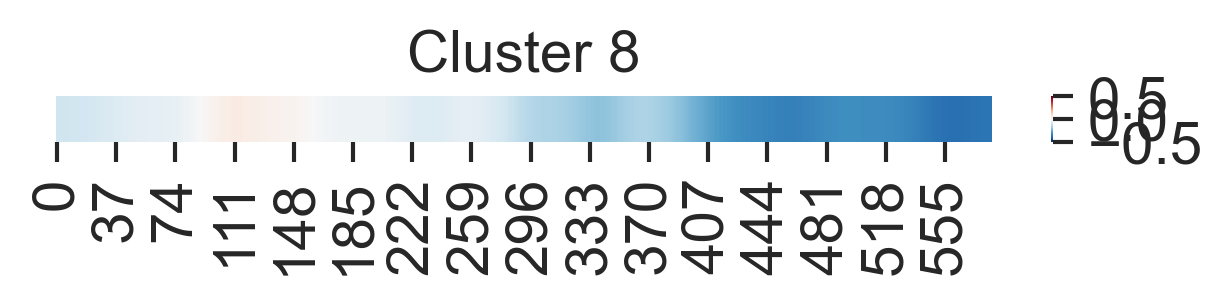

In [1083]:
fig, ax = plt.subplots(figsize=(5, 0.2))

data = adata_draw[adata_draw.obs.path == "Path 8"].copy()
data = data[np.argsort(data.obs.t)].X.T[0].copy()
data = pd.DataFrame(data).T
data = pd.DataFrame([gaussian_filter(data.iloc[i], sigma=sigma) for i in range(data.shape[0])])

sns.heatmap(data, ax=ax, cmap="RdBu_r", vmin=-0.5, vmax=0.5)
ax.set_title("Cluster 8")

plt.savefig(f"figures/bone_related_genes/bone_signature_trajectory_8.pdf", bbox_inches="tight")

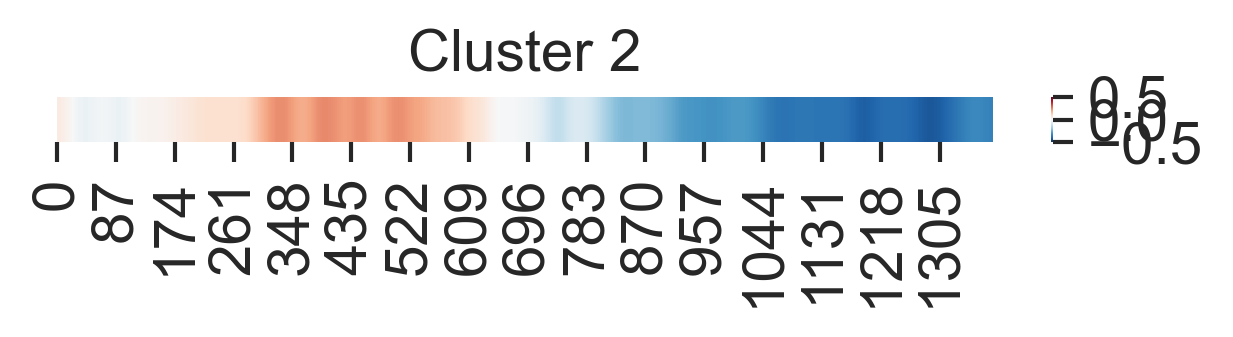

In [1084]:
fig, ax = plt.subplots(figsize=(5, 0.2))

data = adata_draw[adata_draw.obs.path == "Path 2"].copy()
data = data[np.argsort(data.obs.t)].X.T[0].copy()
data = pd.DataFrame(data).T
data = pd.DataFrame([gaussian_filter(data.iloc[i], sigma=sigma) for i in range(data.shape[0])])

sns.heatmap(data, ax=ax, cmap="RdBu_r", vmin=-0.5, vmax=0.5)
ax.set_title("Cluster 2")

plt.savefig(f"figures/bone_related_genes/bone_signature_trajectory_2.pdf", bbox_inches="tight")

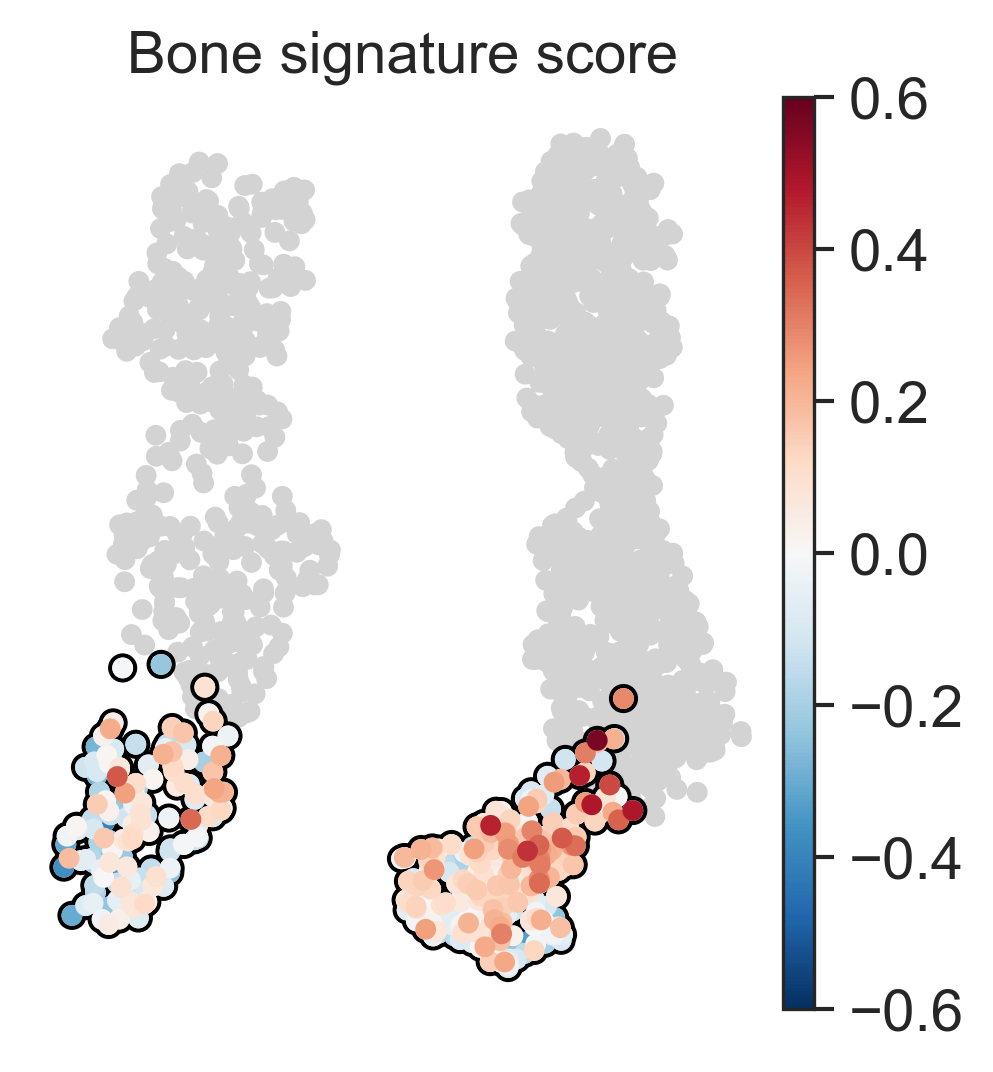

In [1086]:
fig, ax = plt.subplots(figsize=(3.5, 4))

sc.pl.umap(adata_plot_prebifurc, ax=ax, show=False, s=100, frameon=False)
sc.pl.umap(adata_plot_prebifurc[adata_plot_prebifurc.obs.t <= 0.3],  ax=ax, show=False, title="Bone signature score",
           s=100, frameon=False, add_outline=True, outline_width=(0.2, 0), color="bone_score", alpha=1, cmap="RdBu_r", vmin=-0.6, vmax=0.6)

plt.savefig("figures/bone_related_genes/early_activation.pdf")

## Canonical early genes detection

In [681]:
adata_bifurcation = sc.read_h5ad("pathes_objects/path_2_fitted.h5ad")
df = adata_bifurcation.uns["Root->Bone<>Cartilage"]["fork"]
df_early = df[(df.module == "early") & (df.branch == "Bone")].sort_values("up_A")

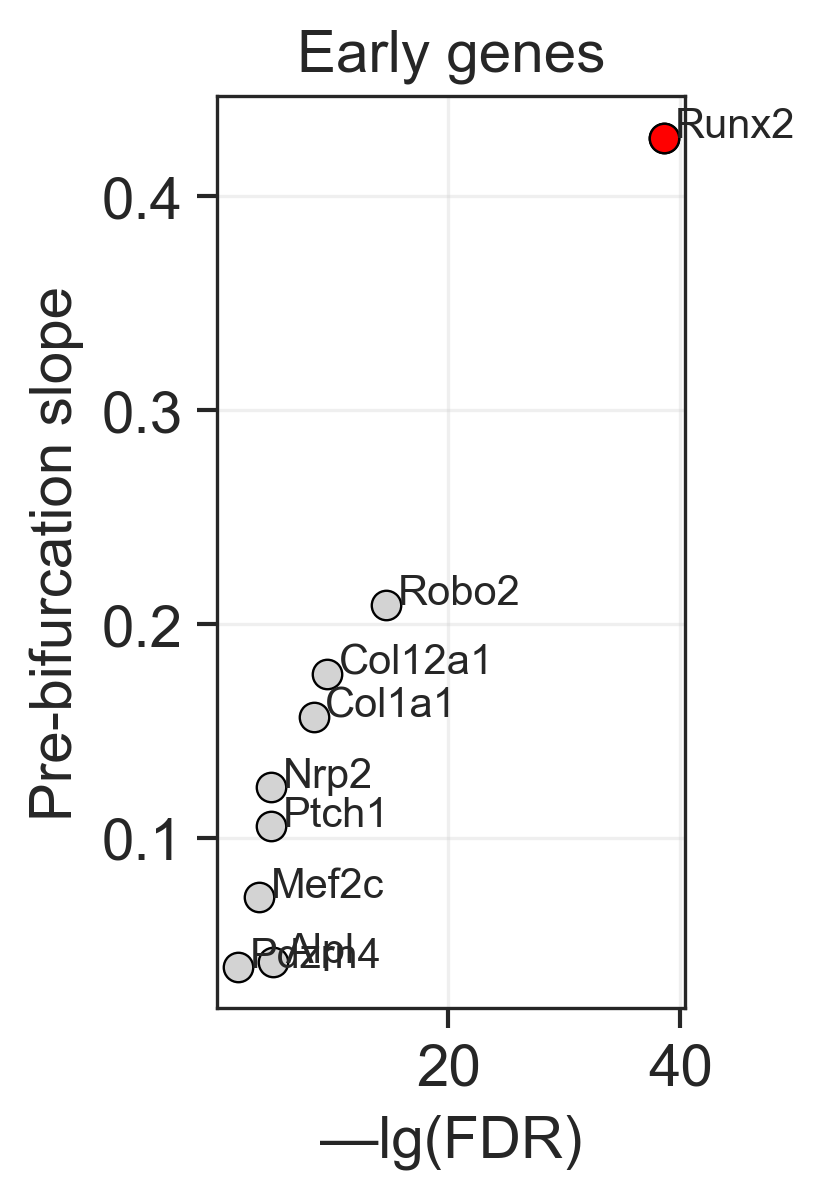

In [722]:
fig, ax = plt.subplots(figsize=(2, 4))

sns.scatterplot(
    x=-np.log10(df_early.pre_fdr),
    y=df_early.slope,
    s=50,
    color="lightgrey",
    edgecolor="black",
    ax=ax,
)

sns.scatterplot(
    x=-np.log10(df_early[df_early.slope > 0.3].pre_fdr),
    y=df_early[df_early.slope > 0.3].slope,
    s=50,
    color="red",
    edgecolor="black",
    ax=ax,
)

for gene, row in df_early.iterrows():
    ax.text(x=-np.log10(row.pre_fdr) + 1, y=row.slope, s=gene, size=10)

ax.set_xlabel("—lg(FDR)")
ax.set_ylabel("Pre-bifurcation slope")
ax.grid(alpha=0.3)
ax.set_title("Early genes")

plt.savefig("figures/early_genes.pdf")

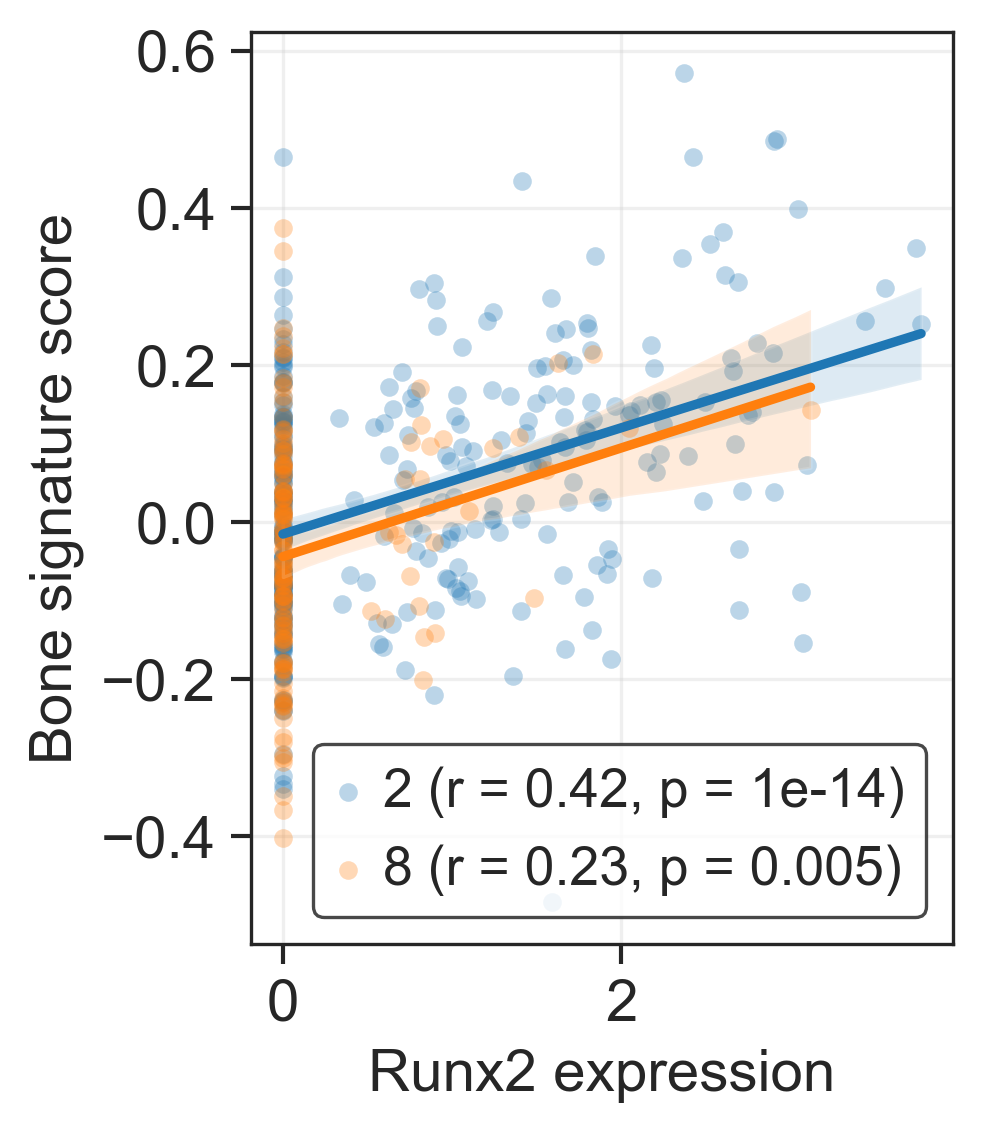

In [1087]:
from scipy.stats import pearsonr

adata_tmp = adata_plot_prebifurc[adata_plot_prebifurc.obs.t <= 0.3].copy()

bone_2 = adata_tmp[adata_tmp.obs.batch == "0"].obs["bone_score"].values
runx2_2 = adata_tmp[adata_tmp.obs.batch == "0", "Runx2"].X.A.T[0]
corr_2 = np.round(pearsonr(bone_2, runx2_2).statistic, 2)
p_2 = int(np.round(np.log10(pearsonr(bone_2, runx2_2).pvalue), 0))

bone_8 = adata_tmp[adata_tmp.obs.batch == "1"].obs["bone_score"].values
runx2_8 = adata_tmp[adata_tmp.obs.batch == "1", "Runx2"].X.A.T[0]
corr_8 = np.round(pearsonr(bone_8, runx2_8).statistic, 2)
p_8 = np.round(pearsonr(bone_8, runx2_8).pvalue, 3)

fig, ax = plt.subplots(figsize=(3, 4))

sns.regplot(
    x=runx2_2,
    y=bone_2,
    ax=ax,
    scatter_kws={
        "alpha": 0.3,
        "color": sns.color_palette()[0],
        "s": 20,
        "linewidth": 0,
    },
    label=f"2 (r = {corr_2}, p = 1e{p_2})",
)

sns.regplot(
    x=runx2_8,
    y=bone_8,
    ax=ax,
    scatter_kws={
        "alpha": 0.3,
        "color": sns.color_palette()[1],
        "s": 20,
        "linewidth": 0,
    },
    label=f"8 (r = {corr_8}, p = {p_8})",
)

ax.grid(alpha=0.3)
ax.set_xlabel("Runx2 expression")
ax.set_ylabel("Bone signature score")

ax.legend(edgecolor="k")

plt.savefig("figures/bone_related_genes/early_correlation_Runx2.pdf")

## Detailed regulation

In [273]:
adata_1_subset = adata_1[adata_combined[adata_combined.obs.path == "Path 2"].obs_names].copy()
path2_genes = adata_combined.var[(adata_combined.var["cov_fdr"] < 1e-5) & (adata_combined.var["Path 2->Path 8_lfc"] > 1)].sort_values("cov_fdr")
adata_1_subset = adata_1_subset[:, path2_genes.index]

In [275]:
manual_test(adata_1_subset)

100%|██████████| 60/60 [00:07<00:00,  8.26it/s]


In [277]:
scf.tl.cluster(adata_1_subset, n_pcs=20, device="cuda:0", resolution=0.5, n_neighbors=10)
set(adata_1_subset.var.clusters)

Clustering features using fitted layer
    finished (0:00:05) --> added 
    .var['clusters'] identified modules.


{'0', '1', '2'}

In [710]:
genes_of_interest = adata_1_subset.var[adata_1_subset.var.clusters == "0"].index.values
genes_of_interest

array(['Alx1', 'Tbx3', 'Sim2', 'Lrriq1', 'Tnn', 'Tbx3os1', 'Eya4',
       'Sfrp1', 'Dpysl3', 'Nrp2', 'Sema3e', 'Cpm', 'Cacna1d', 'Sytl5',
       'Adamts12', 'Acer2', 'Emb', 'Itga6', 'Fhod3', 'Crip2', 'Dclk2',
       'Rnf128'], dtype=object)

In [303]:
TF_targets = {}

with open("pySCENIC_cartilage/regulons_genes.txt", "r") as f:
    counter = 0
    for line in f:
        if counter % 3 == 0:
            gene = line.strip()
        elif counter % 3 == 1:
            TF_targets[gene] = line.strip().split(", ")
        counter += 1

In [594]:
import gseapy as gp

enr_up = gp.enrichr(
    list(genes_of_interest),
    gene_sets=TF_targets,
    outdir=".",
    background=adata_plot.var_names[(adata_plot.X.sum(axis=0) > 2).A[0]],
)

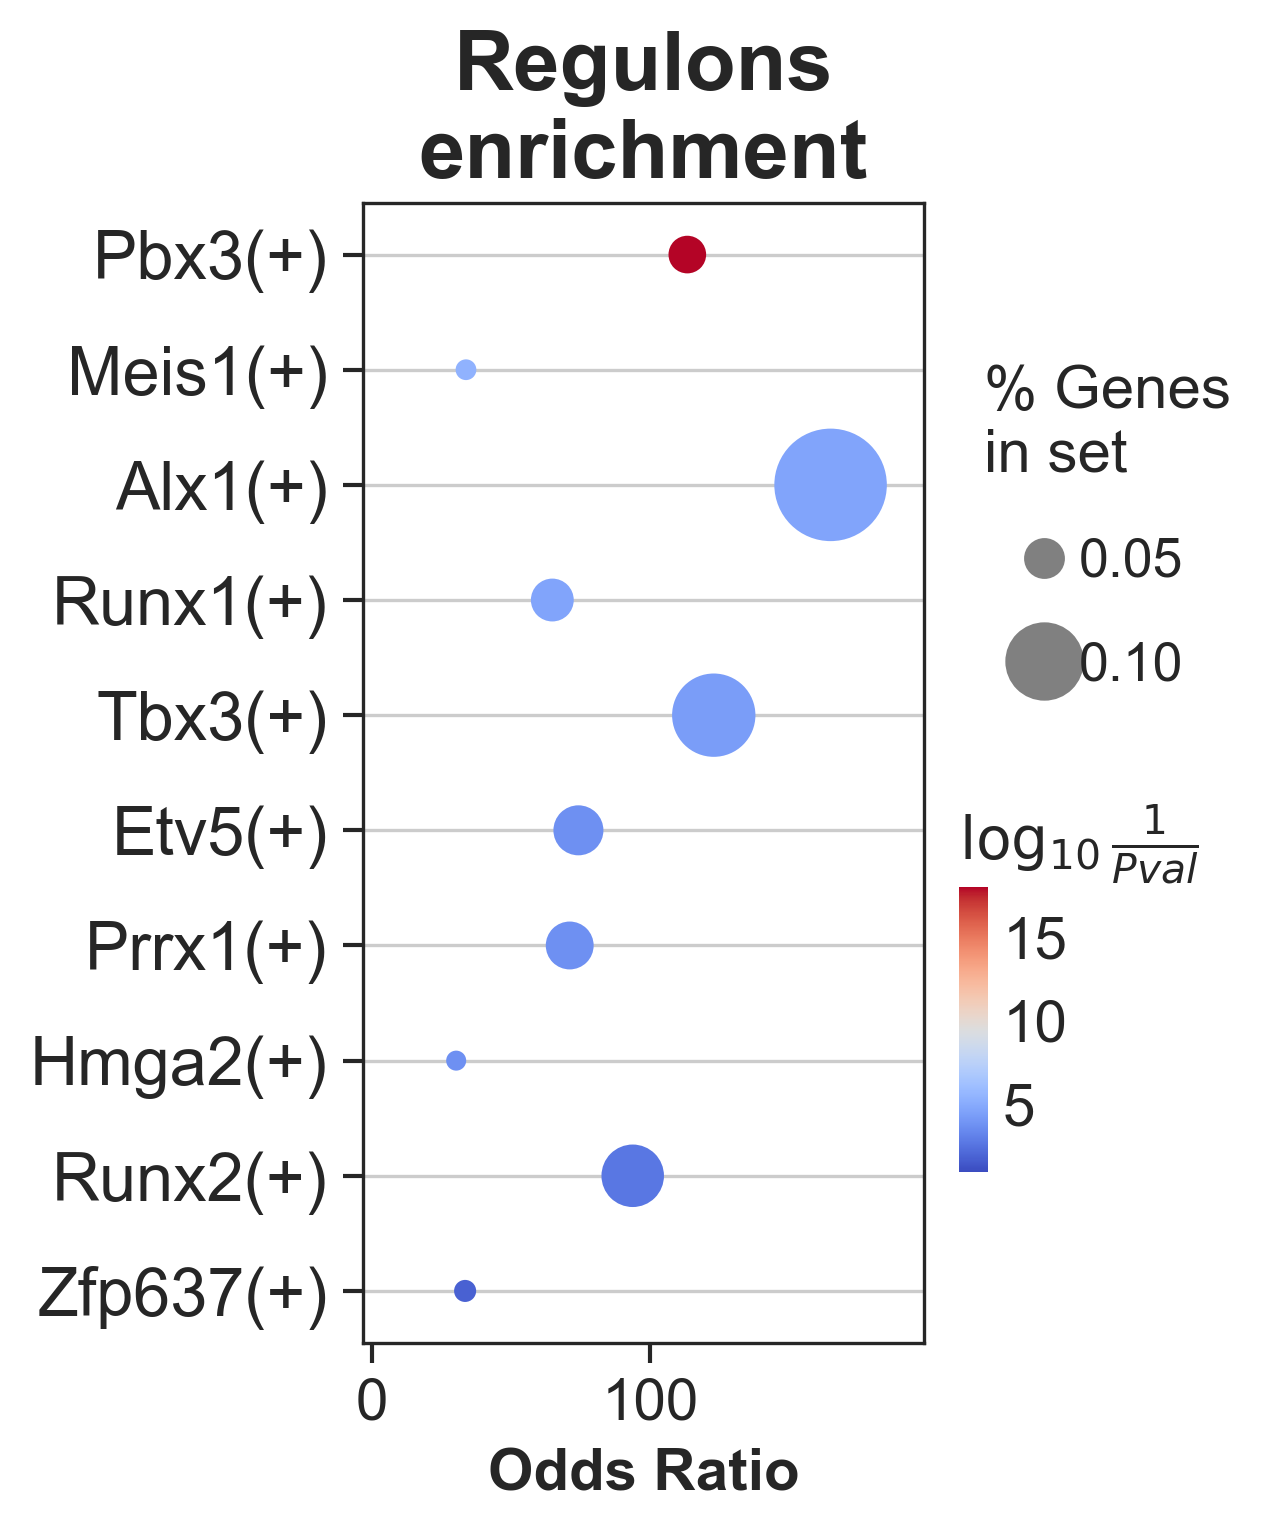

In [612]:
# dotplot
gp.dotplot(
    enr_up.res2d,
    figsize=(3,5),
    title="Regulons\nenrichment",
    cmap="coolwarm",
    size=30,
)
plt.savefig("figures/regulons_enrichment.pdf")

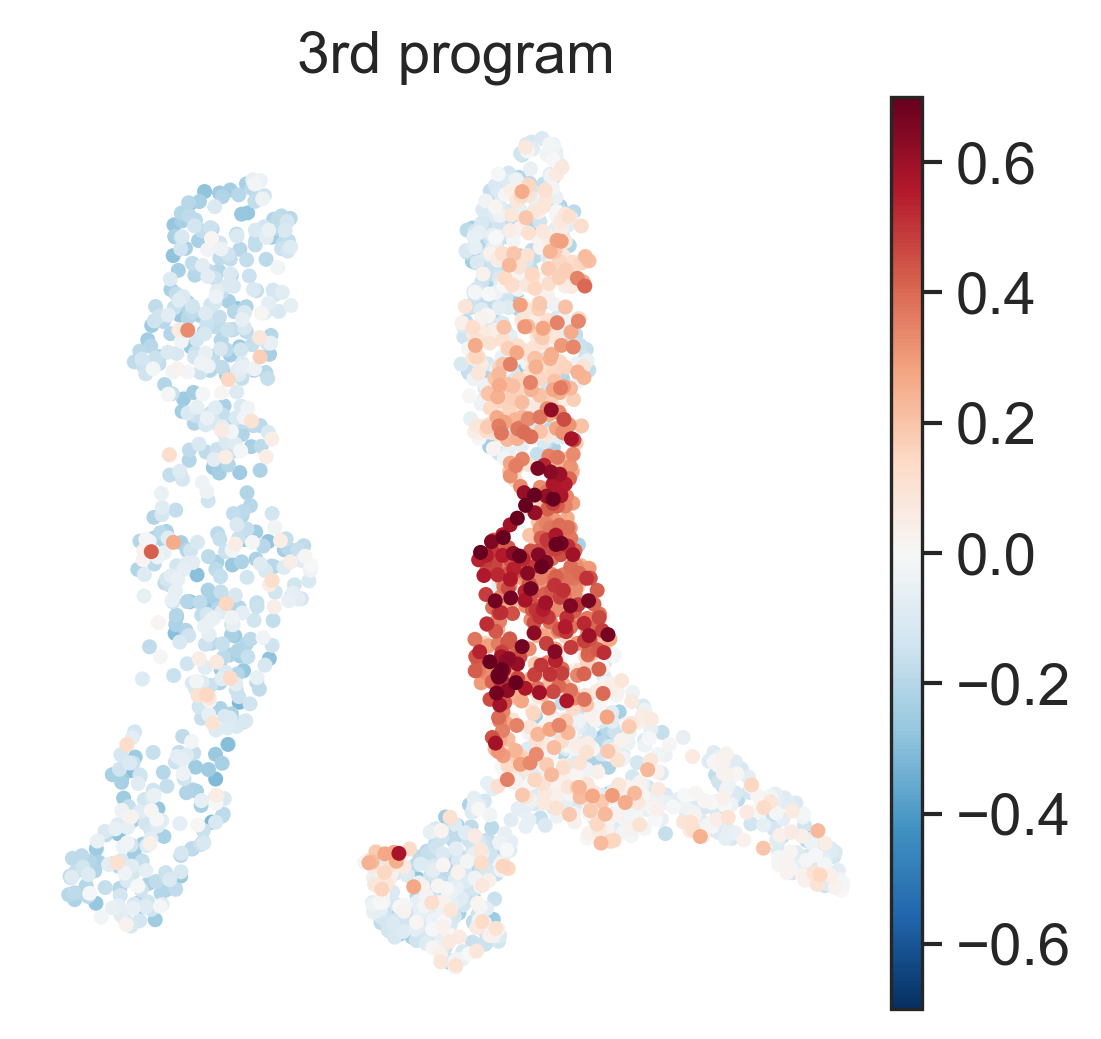

In [532]:
sc.tl.score_genes(adata_plot, gene_list=genes_of_interest, score_name="cluster2-specific_signature")

sc.pl.umap(adata_plot, color="cluster2-specific_signature", cmap="RdBu_r", vmin=-0.7, vmax=0.7, title="3rd program",
           frameon=False, save="cluster2-specific_signature.pdf")

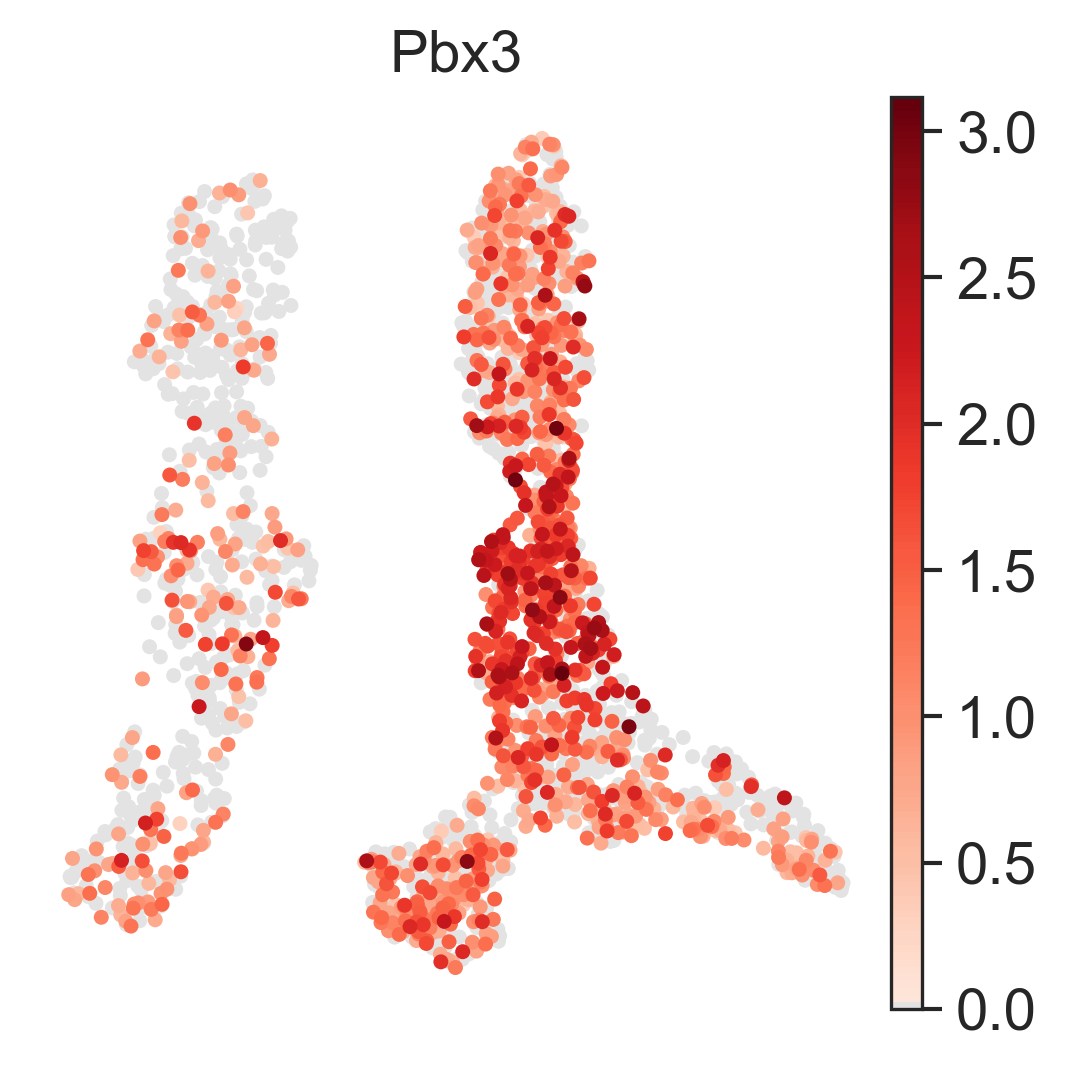

In [533]:
sc.pl.umap(adata_plot, color=["Pbx3"], frameon=False, cmap=mb.pl.beautiful_cmap(), save="pbx3.pdf")

In [1088]:
scenic = sc.read_h5ad("../../antonia/pySCENIC_cartilage/scenic.h5ad")

adata_1_scenic = scenic[adata_1.obs_names].copy()
adata_1_scenic.obs = adata_1.obs.copy()
adata_1_scenic.uns = adata_1.uns.copy()
adata_1_scenic.obsm = adata_1.obsm.copy()

adata_2_scenic = scenic[adata_2.obs_names].copy()
adata_2_scenic.obs = adata_2.obs.copy()
adata_2_scenic.uns = adata_2.uns.copy()
adata_2_scenic.obsm = adata_2.obsm.copy()

adata_combined_scenic = scenic[adata_combined.obs_names].copy()
adata_combined_scenic.obs = adata_combined.obs.copy()
adata_combined_scenic.uns = adata_combined.uns.copy()
adata_combined_scenic.obsm = adata_combined.obsm.copy()

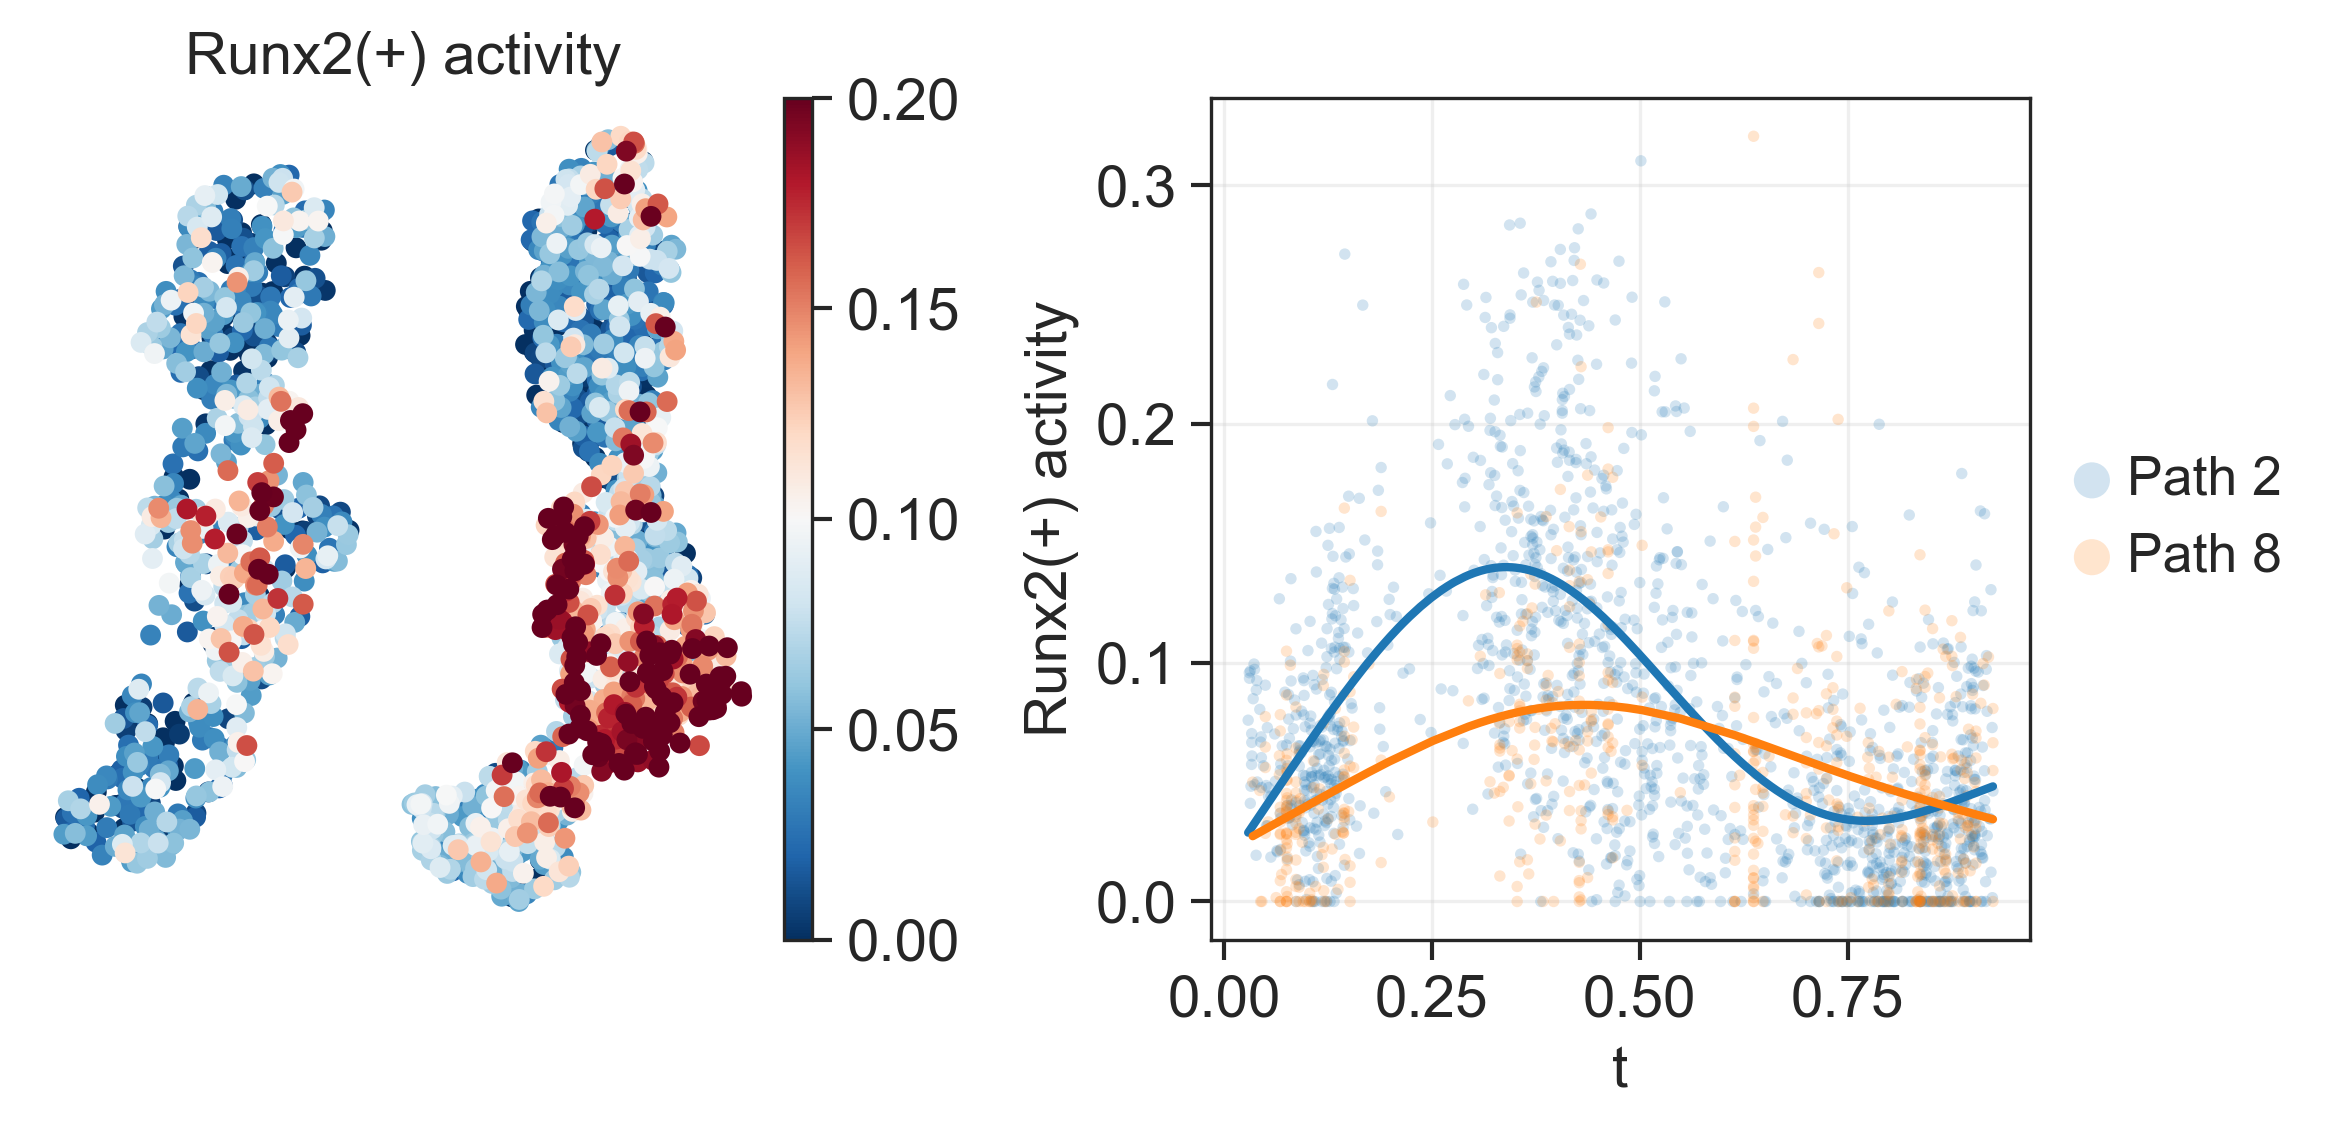

In [1089]:
adata_plot_runx2 = adata_plot[adata_plot.obs.seg != "3"].copy()
adata_plot_runx2.obs["bone_score"] = scenic[adata_plot_runx2.obs_names, "Runx2(+)"].X.T[0].copy()

adata_draw = sc.AnnData(
    X=scenic[adata_combined.obs_names][:, "Runx2(+)"].X.copy(),
    var=pd.DataFrame(index=["bone_score"]),
    obs=adata_combined.obs[["path", "t"]]
)

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(adata_plot_runx2, color="bone_score", cmap="RdBu_r",
           vmax=0.2, vmin=0, s=100, ax=axes[0], show=False, frameon=False, title="Runx2(+) activity")

scf.pl.trend_covariate(
    adata_draw,
    gene="bone_score",
    group_key="path",
    alpha=0.2,
    size=30,
    show=False,
    ax=axes[1],
)
axes[1].grid(alpha=0.3)
axes[1].set_ylabel("Runx2(+) activity")
axes[1].set_title("")

fig.tight_layout()

plt.savefig(f"figures/Runx2_activity.pdf", bbox_inches="tight")